In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Personal\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [3]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [4]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [5]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


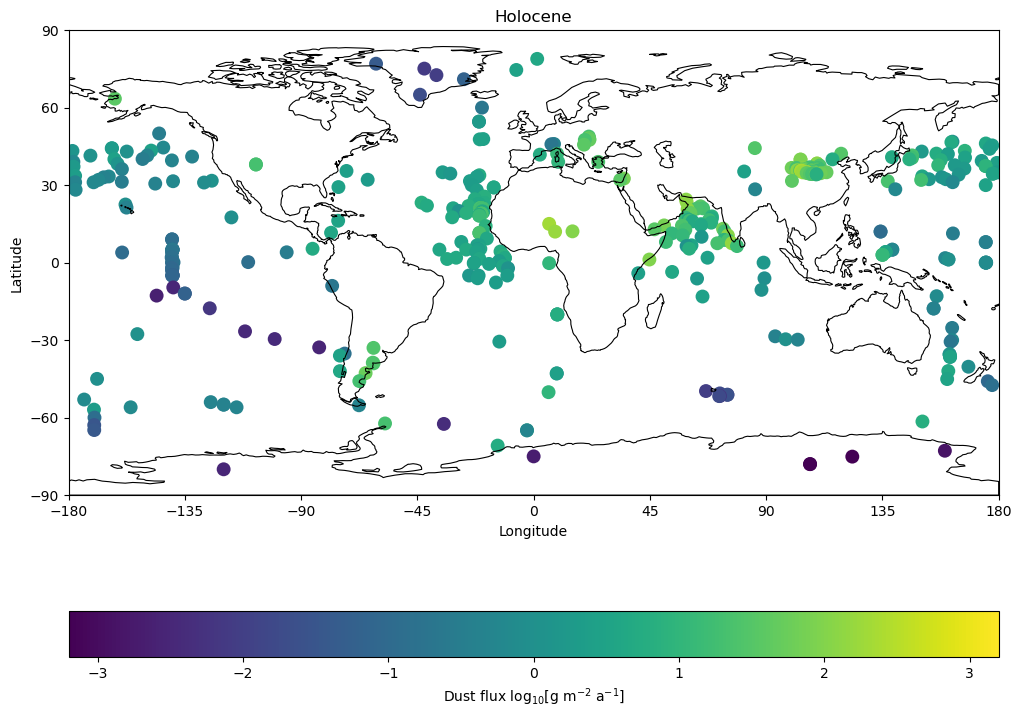

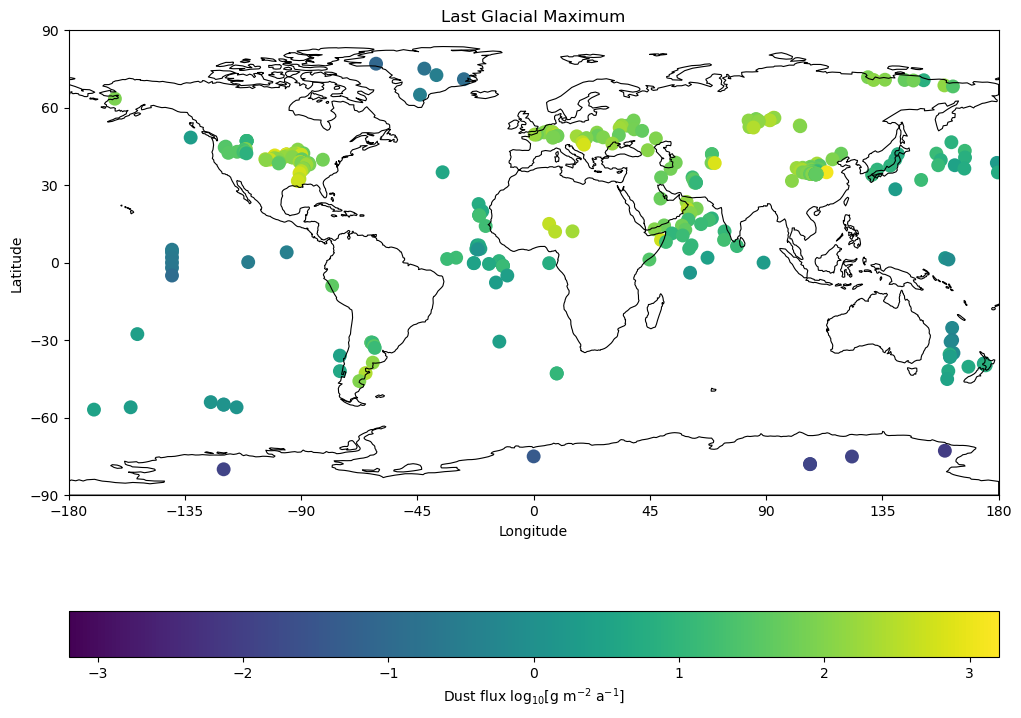

In [6]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [7]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

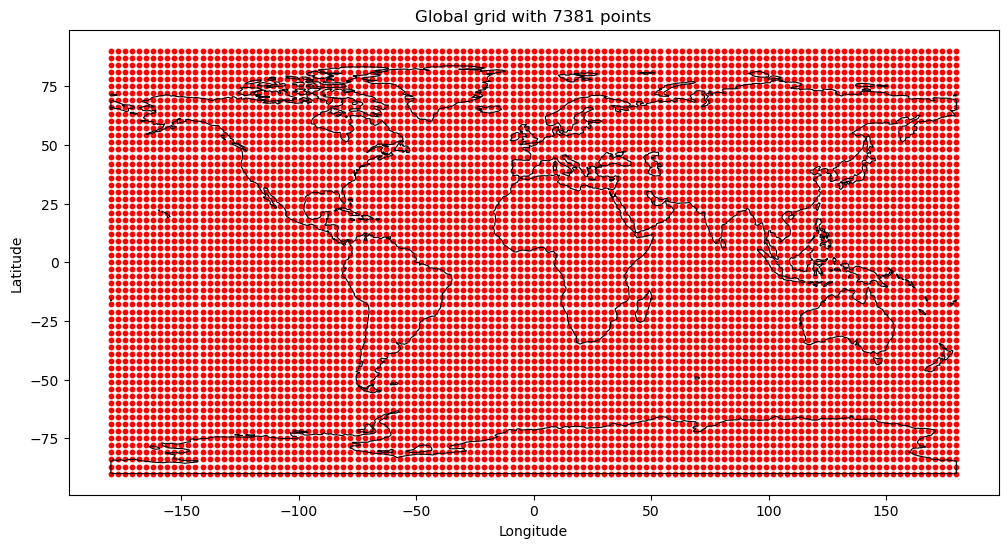

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [9]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [10]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    """
    Revisando los dataframes y las siguientes funciones que usan distance_(tipo de distancia)
    Además, junto con el apoyo y explicacion de chatgpt, concluyo con la siguiente implementacion de la formula geodesica
    """
    R = 6371.0  # Usando el radio de la tierra en km
    lon1, lat1 = np.radians(x)
    lon2, lat2 = np.radians(y)

    arc_angle = np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1))

    distance = R * arc_angle
    return distance


In [11]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [12]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [13]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

# Aplicamos lo anterior pero con la distancia geodesica

estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic

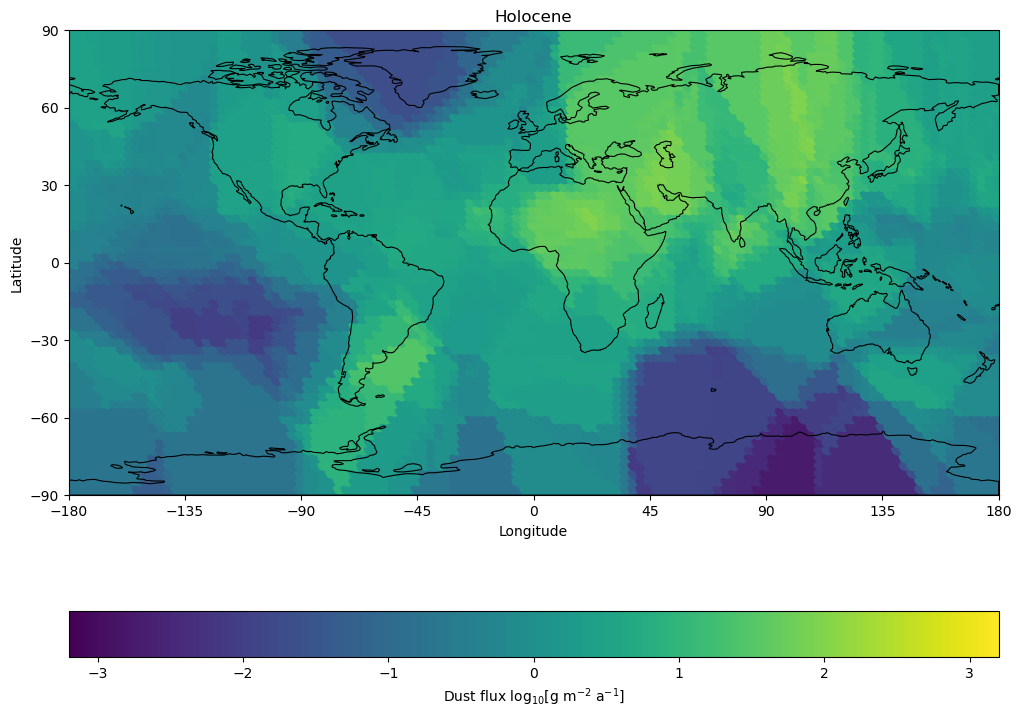

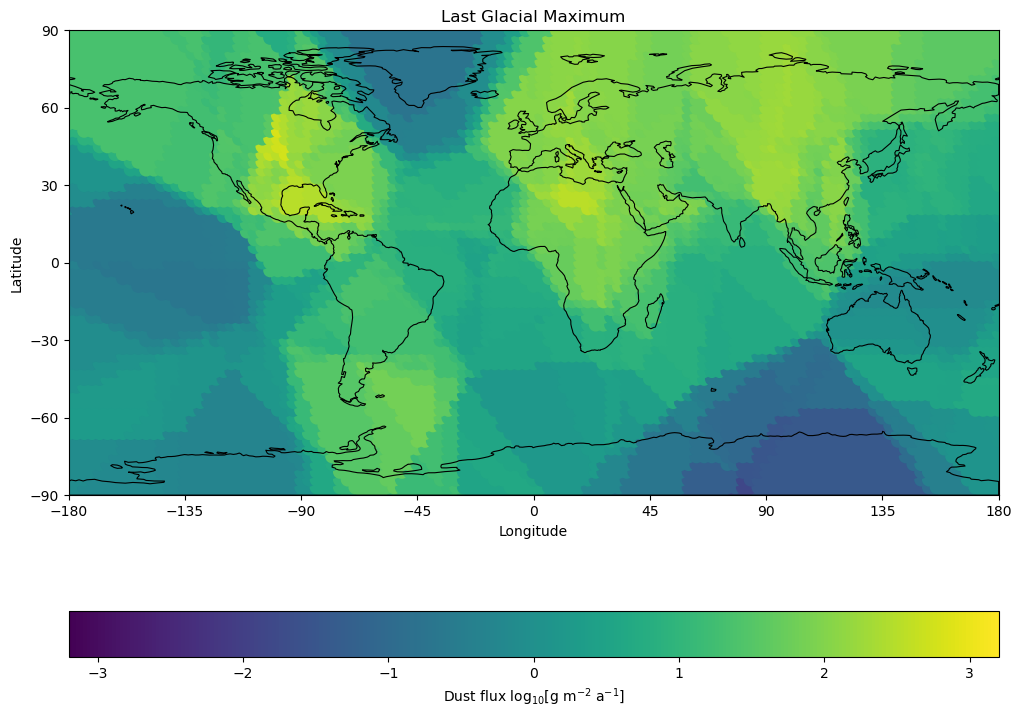

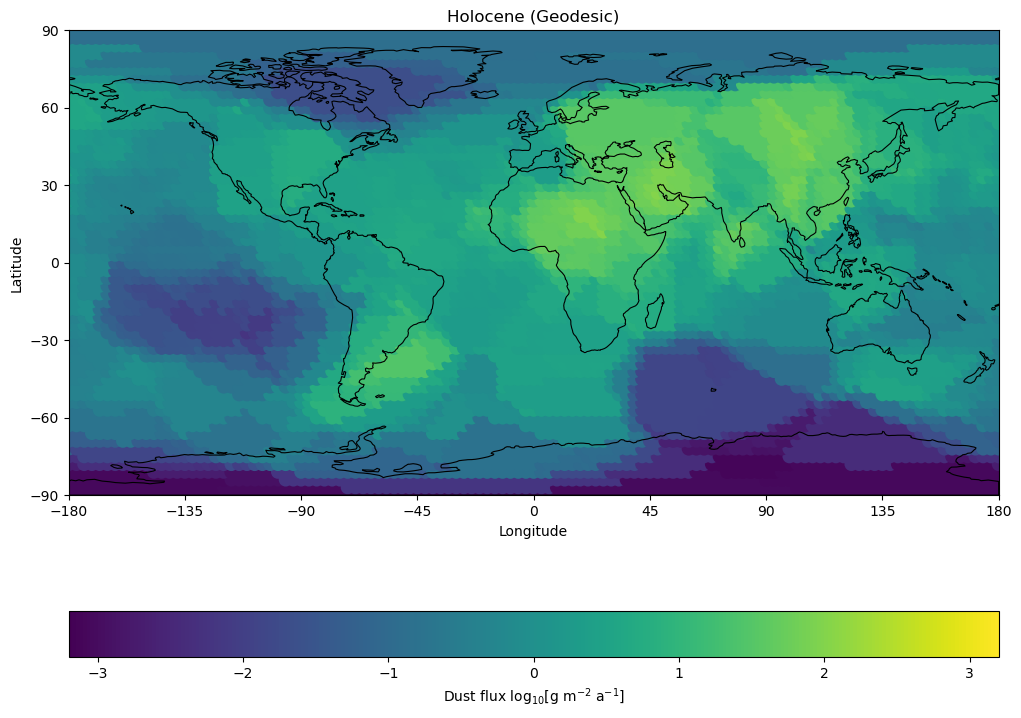

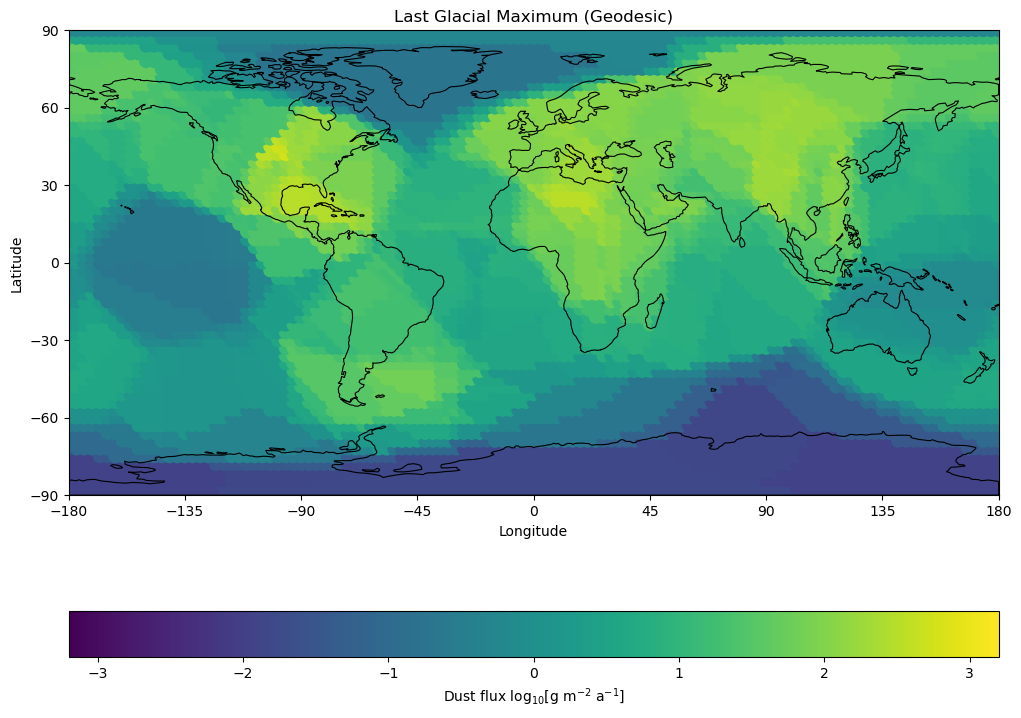

In [14]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

# Nuevamente aplicamos lo anterior pero con la distancia geodesica

plot_dust_deposition_map(df=df_global_grid,
                            title='Holocene (Geodesic)',
                            name_to_save='ESTIMATION_MAP_HOLOCENE_GEODESIC',
                            label_str='est_hol_geodesic')

plot_dust_deposition_map(df=df_global_grid,
                            title='Last Glacial Maximum (Geodesic)',
                            name_to_save='ESTIMATION_MAP_LGM_GEODESIC',
                            label_str='est_lgm_geodesic')

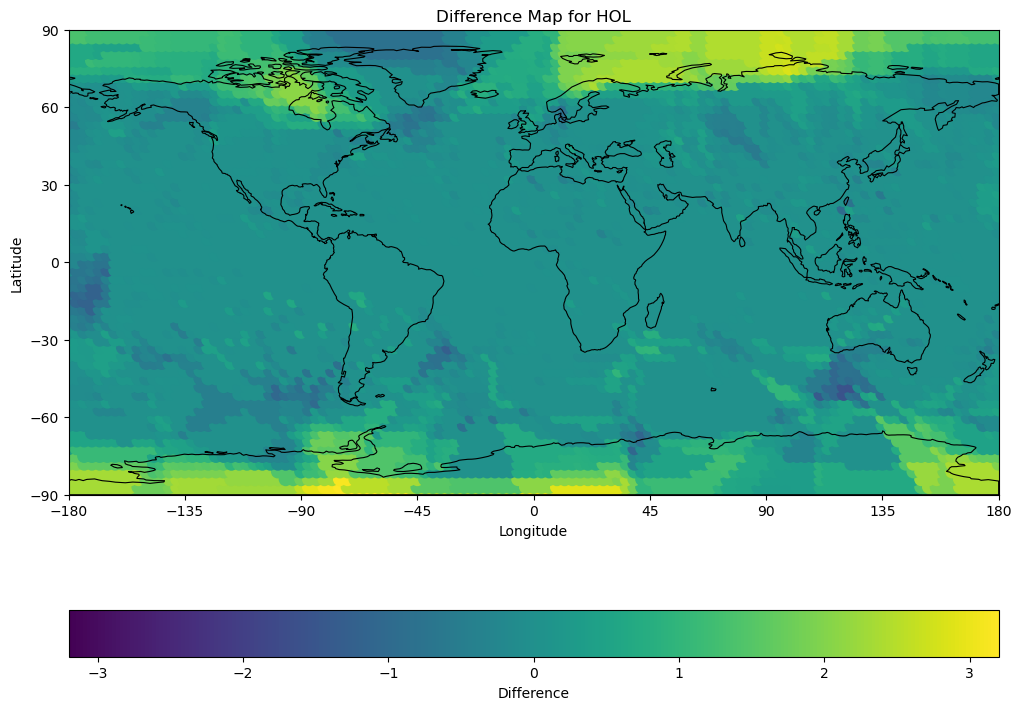

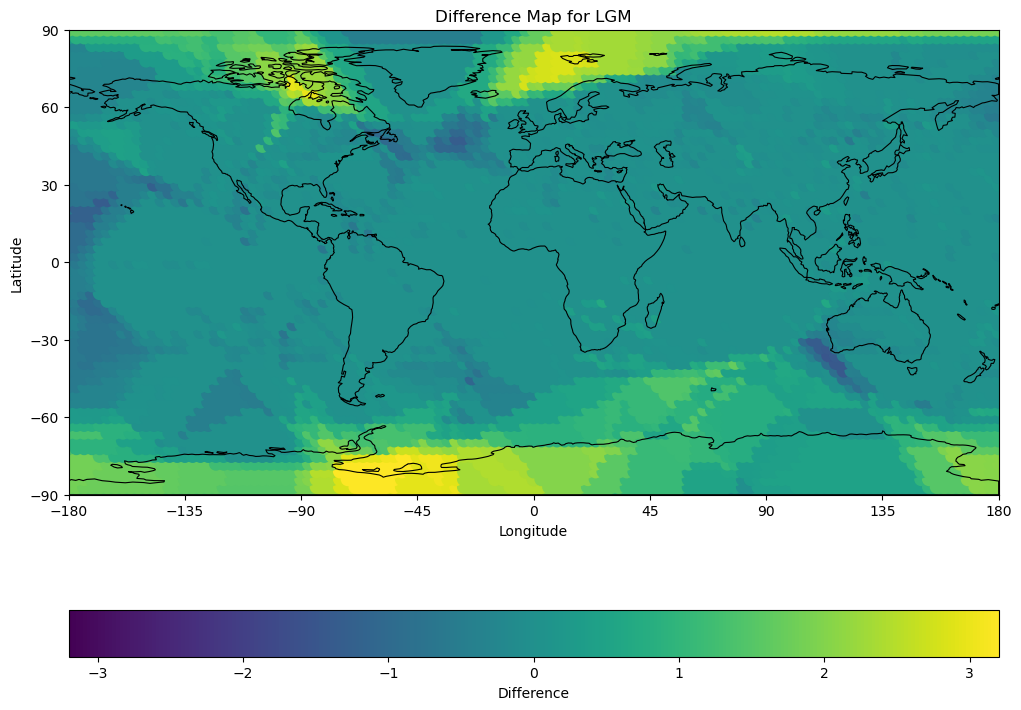

In [16]:
"""
Para calcular la diferencia entre los dos métodos decidi agregar una nueva columna al dataframe
Con el proposito de luego graficarlo de alguna manera
"""
df_global_grid["diff_hol"] = df_global_grid["est_hol"] - df_global_grid["est_hol_geodesic"]
df_global_grid["diff_lgm"] = df_global_grid["est_lgm"] - df_global_grid["est_lgm_geodesic"]

"""
Luego de algunas otras pruebas decidi apoyarme en copilot y usar la funcion "plot_dust_deposition_map" como referencia
Así podria graficar de mejor manera las diferencias entre ambas distancias
"""
def plot_difference_map(df, title, name_to_save, diff_column, measure_units='Difference', limit_bar = 3.2):
    """Generate a map plot of the difference based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the difference data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - diff_column (str): The column name in the dataframe to use for labeling the data on the plot.
    - measure_units (str, optional): The units of measurement for the difference. Defaults to 'Difference'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_geopandas.plot(column=diff_column,
                      ax=ax,
                      legend=True,
                      legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                      cmap='viridis',
                      vmin=-limit_bar,
                      vmax=limit_bar,
                      linewidth=0.005,
                      markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return

plot_difference_map(df_global_grid, 'Difference Map for HOL', 'diff_map_hol', 'diff_hol')
plot_difference_map(df_global_grid, 'Difference Map for LGM', 'diff_map_lgm', 'diff_lgm')

Respuestas y discusión sobre las diferencias entre distancia geodesica y euclidiana:

Como se puede apreciar en los mapas anteriores las mayores diferencias entre ambos metodos de medición se dan en los polos del planeta, esto puede deberse a que la distancia geodésica toma en cuenta la curvatura de la tierra dando diferentes resultados dependiendo de la latitud y la longitud de la zona, a diferencia de la euclidiana que se aplica tomando en cuenta un plano, por lo mismo tambien se responde "trivialmente" cual es la mejor cuando se busca medir en longitud 180°, siendo mejor la geodesica pues esta es la que se aproxima de manera mas fidedigna a la linea del antimeridiano (concepto investigado brevemente).

En cuanto a Cuáles son las diferencias entre los resultados para el Holoceno y el LGM. Utilizando el codigo original de la visualizacion de sedimentos "plot_dust_deposition_map", se puede notar que al aplicar el metodo euclidiano, la representacion de las mediciones se ve muy plana en el mapa mundial, extendiendose mas notoriamente de manera vertical, cosa que no ocurre con el metodo geodesico, en el cual se puede apreciar cierta curvatura y mejor deficinión, haciendome personalmente mas sentido teniendo en cuenta que lo se mide es la superficie de una esfera "la tierra"

En cuanto al numero de vecinos cercanos a elegir, según lo que logré investigar, los mayores factores a considerar al elegir la cantidad de vecinos cercanos sería el tamaño del conjunto de datos y la densidad de los datos, ahora bien, en este caso, desconozco con exactitud como funciona el flujo y la dispersion de sedimentos, pero suponiendo que se guian por ciertas corrientes de viento y en grandes grupos (de particulas), creo que es correcto asumir que en este caso nuestro set de datos es grande y dependiendo de la zona, denso o disperso, por tanto, en zonas de alta densidad, menos vecinos cercanos seria una mejor opcion para obtener mejores estimaciones, y más vecinos en el caso de menor densidad de datos.